,X,patient,time,rejection,match
,<int>,<int>,<int>,<int>,<int>
1,1,1,29,1,0
2,2,1,37,1,1
3,3,2,3,1,0
4,4,2,19,1,1
5,5,3,15,1,0
6,6,3,57,0,1


       X            patient            time         rejection     
 Min.   : 1.00   Min.   : 1.000   Min.   : 3.00   Min.   :0.0000  
 1st Qu.: 9.25   1st Qu.: 4.250   1st Qu.:18.00   1st Qu.:1.0000  
 Median :17.50   Median : 8.500   Median :22.50   Median :1.0000  
 Mean   :17.50   Mean   : 8.176   Mean   :30.21   Mean   :0.8529  
 3rd Qu.:25.75   3rd Qu.:11.000   3rd Qu.:35.00   3rd Qu.:1.0000  
 Max.   :34.00   Max.   :16.000   Max.   :93.00   Max.   :1.0000  
     match       
 Min.   :0.0000  
 1st Qu.:0.0000  
 Median :0.0000  
 Mean   :0.4118  
 3rd Qu.:1.0000  
 Max.   :1.0000  

[1] 34  5

'data.frame':	34 obs. of  5 variables:
 $ X        : int  1 2 3 4 5 6 7 8 9 10 ...
 $ patient  : int  1 1 2 2 3 3 3 4 4 5 ...
 $ time     : int  29 37 3 19 15 57 57 26 93 11 ...
 $ rejection: int  1 1 1 1 1 0 0 1 1 1 ...
 $ match    : int  0 1 0 1 0 1 1 0 1 0 ...


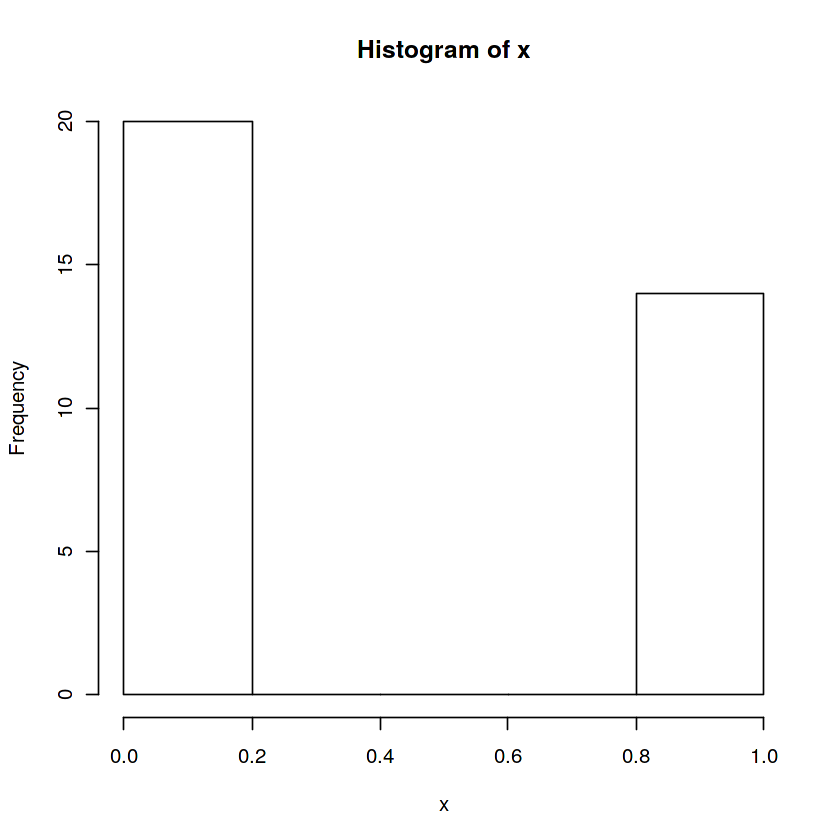

In [4]:
##Load Libraries

library(ggplot2)
library(tidyverse)
library(dplyr)
library(readr)
library(cowplot)
library(olsrr)
library(caret)
library(pscl)
library(lmtest)
library(ipred)
library(survival)
library(ResourceSelection)
library(survey)
library(lmtest)
library(pROC)
library(DescTools)

## NOTE: This is a proof of concept. Further validation work needs to take place.
##need to create train/datasets

data = read.csv('../input/allograft-data/allograft.csv', stringsAsFactors = F)
head(data) #allows you to check the data, first few entries 
summary(data) #produce result summaries of the results of various model fitting functions.
dim(data) #the dimension (e.g. the number of columns and rows) of a matrix, array or data frame. 
str(data) 
# this shows that we need to tell R which columns contain factors
# it will also show us if there are some missing values.
x<-data$match
hist(x)

In [5]:
#Baseline Accuracy
table(x)

x
 0  1 
20 14 

In [6]:
#CATOOLS
library(caTools)
set.seed(123)
split = sample.split(x, SplitRatio = 0.80) 

datatrain = subset(data, split==TRUE)
datatest = subset(data, split==FALSE)

head(datatrain)
head(datatest)

nrow(datatrain)#Training Samples
nrow(datatest) #Test Samples

,X,patient,time,rejection,match
,<int>,<int>,<int>,<int>,<int>
1,1,1,29,1,0
2,2,1,37,1,1
3,3,2,3,1,0
4,4,2,19,1,1
5,5,3,15,1,0
6,6,3,57,0,1


,X,patient,time,rejection,match
,<int>,<int>,<int>,<int>,<int>
7,7,3,57,0,1
10,10,5,11,1,0
21,21,9,77,1,1
22,22,10,15,1,0
24,24,10,29,1,1
30,30,14,18,1,0


[1] 27

[1] 7

In [24]:
#Logistic Regression Model
formula=match~rejection+time+patient
QualityLog = glm(formula , data=datatrain, family=binomial)
# replace x with the dependent variable 
# replace y with the independent variable(s)

summary(QualityLog)


Call:
glm(formula = formula, family = binomial, data = datatrain)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.4697  -0.8632  -0.4768   0.7472   1.8990  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)
(Intercept)  0.07167    2.57160   0.028    0.978
rejection   -0.81347    1.87479  -0.434    0.664
time         0.05431    0.03441   1.578    0.114
patient     -0.16805    0.11647  -1.443    0.149

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 36.499  on 26  degrees of freedom
Residual deviance: 28.841  on 23  degrees of freedom
AIC: 36.841

Number of Fisher Scoring iterations: 4


In [25]:
#Making predictions using the training set
predictTrain = predict(QualityLog, type="response")
summary(predictTrain)
predictTrain
y=datatrain$match

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.09702 0.24925 0.33641 0.40741 0.50986 0.97433 

1          2          3          4          5          6          8 
0.66040115 0.75017505 0.28598201 0.48848908 0.39380682 0.93481158 0.49949870 
         9         11         12         13         14         15         16 
0.97433504 0.32890552 0.28180982 0.35213809 0.30321882 0.37609205 0.24811572 
        17         18         19         20         23         25         26 
0.25838505 0.33640546 0.52022829 0.76262344 0.19080371 0.37128884 0.81480665 
        27         28         29         31         32         33 
0.15102331 0.16477610 0.10745406 0.09702193 0.09702193 0.25038176

In [26]:
tapply(predictTrain, y, mean)

0         1 
0.3048503 0.5565814

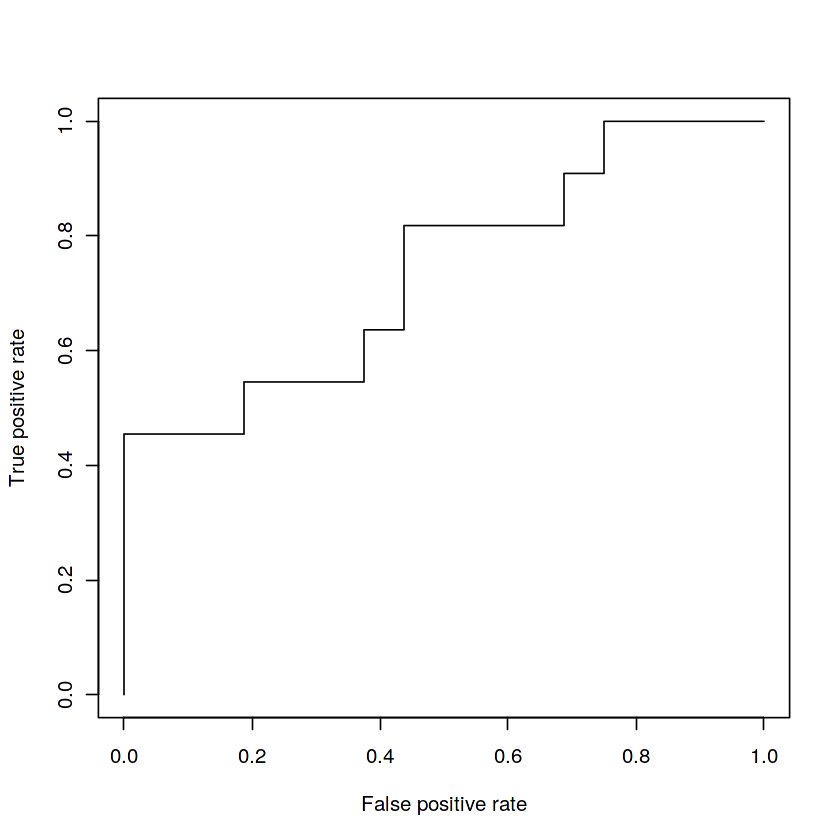

   
y   FALSE TRUE
  0    14    2
  1     6    5

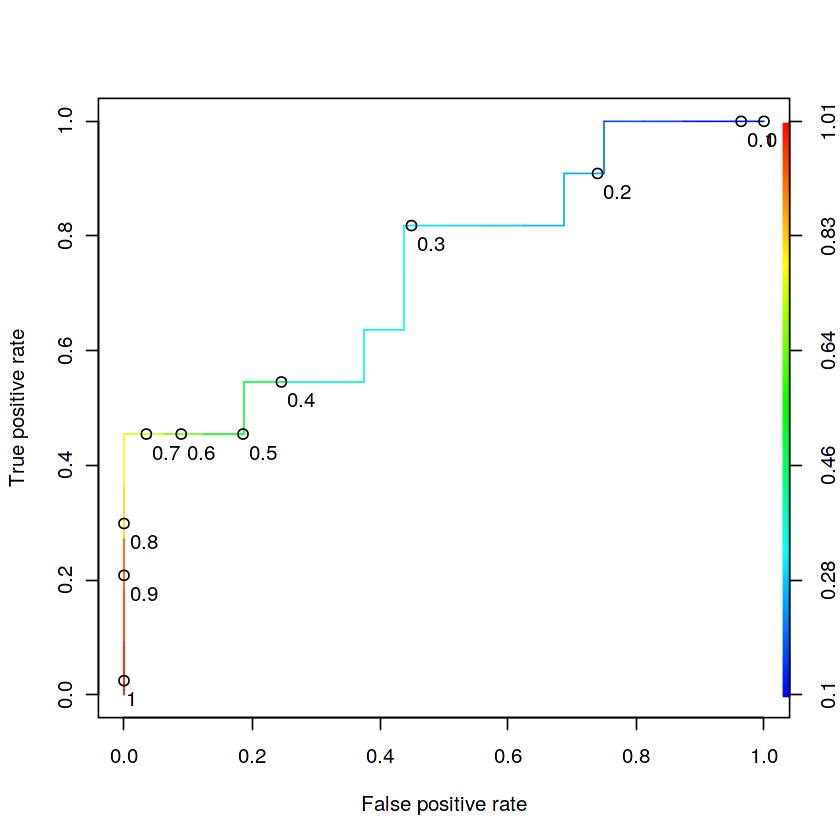

In [27]:
library(ROCR)
ROCRpred = prediction(predictTrain, y)
# Performance function
ROCRperf = performance(ROCRpred, "tpr", "fpr")
# Plot ROC curve
plot(ROCRperf)
# Add colors
plot(ROCRperf, colorize=TRUE)

plot(ROCRperf, colorize=TRUE, print.cutoffs.at=seq(0,1,by=0.1), text.adj=c(-0.2,1.7))


# Confusion matrix for threshold of 0.5 for training set
table(y, predictTrain > 0.5)

#Making prediction on the test set
predictTest = predict(QualityLog, type = "response", newdata = datatest)
z=datatest$match
cm<-table(z,predictTest >= 0.5)

   
z   FALSE TRUE
  0     4    0
  1     1    2

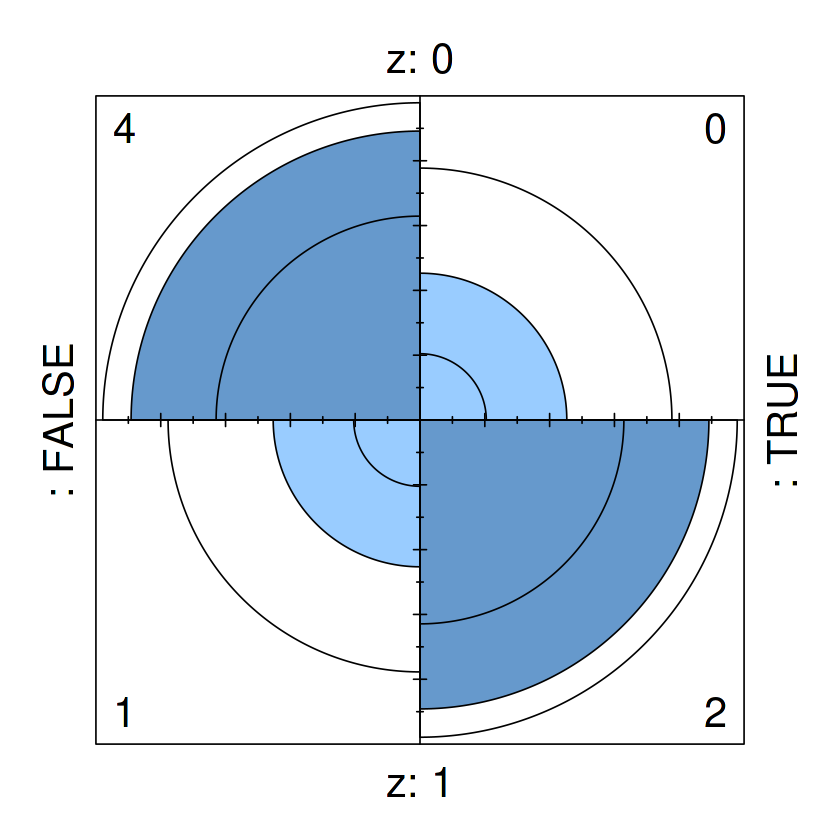

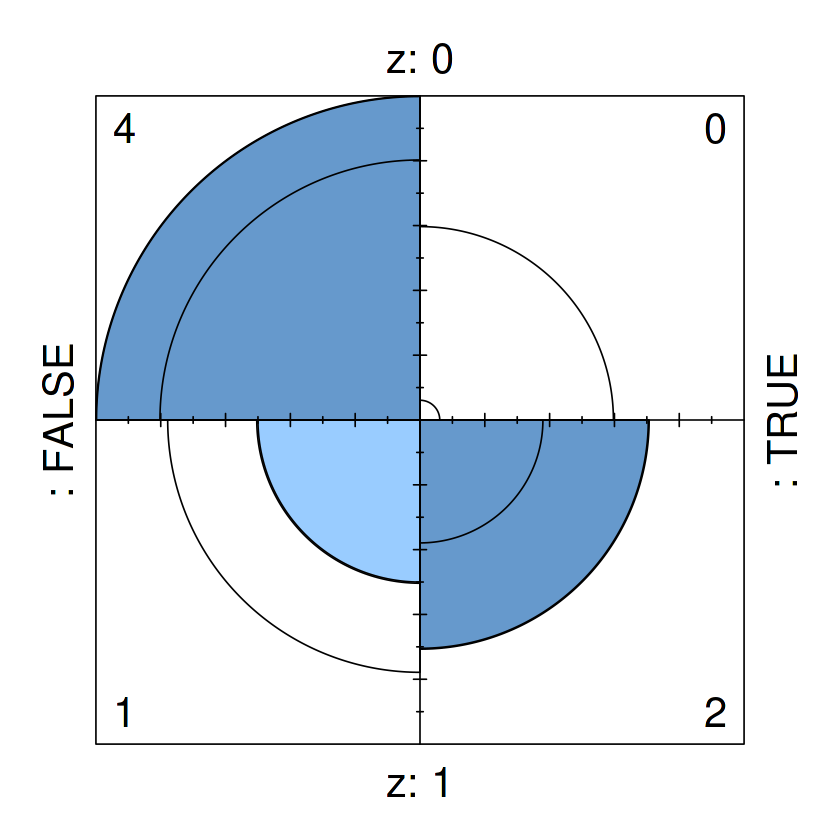

In [28]:
#plotting the confusion matrix
cm
fourfoldplot(cm)
fourfoldplot(cm, std = "all.max")

n = sum(cm) # number of instances
nc = nrow(cm) # number of classes
diag = diag(cm) # number of correctly classified instances per class 
rowsums = apply(cm, 1, sum) # number of instances per class
colsums = apply(cm, 2, sum) # number of predictions per class
p = rowsums / n # distribution of instances over the actual classes
q = colsums / n # distribution of instances over the predicted classes

In [29]:
#Compute the Accuracy
accuracy = sum(diag) / n 
accuracy

[1] 0.8571429

In [30]:
#Compute the Precision
precision = diag / colsums 
precision

FALSE  TRUE 
  0.8   1.0

In [31]:
#Compute the Sensitivity
recall = diag / rowsums 
recall

0         1 
1.0000000 0.6666667

In [32]:
#Compute the F Score
f1 = 2 * precision * recall / (precision + recall) 
f1

FALSE      TRUE 
0.8888889 0.8000000

In [33]:
#Computing the AUC
library(ROCR)
pred = prediction(predictTrain, y)
as.numeric(performance(pred, "auc")@y.values)

pred1 = prediction(predictTest, z)
as.numeric(performance(pred1, "auc")@y.values)

[1] 0.7386364

[1] 1

Setting levels: control = 0, case = 1

Setting direction: controls < cases



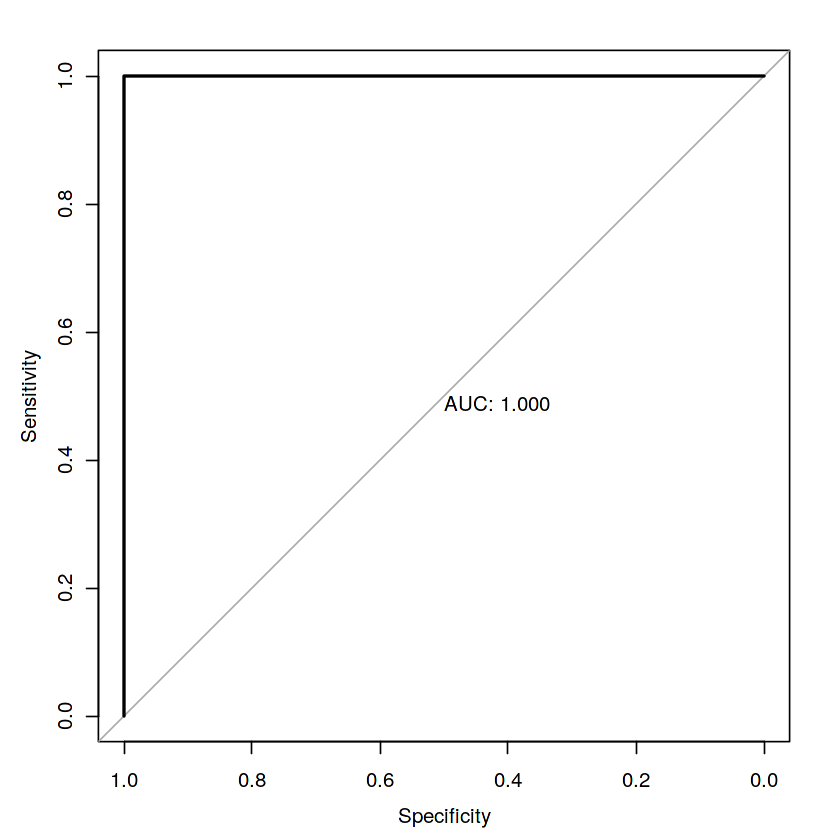

In [34]:
#Plotting the AUC
test_prob = predict(QualityLog, newdata = datatest, type = "response")
test_roc = roc(z ~ test_prob, plot = TRUE, print.auc = TRUE)

In [35]:
#Compute Pseudo R2s
PseudoR2(QualityLog, which="Efron")
PseudoR2(QualityLog, which="McFadden")
PseudoR2(QualityLog, which="CoxSnell")
PseudoR2(QualityLog, which="Nagelkerke")
PseudoR2(QualityLog, which="Tjur")

Efron 
0.2448903

McFadden 
0.2098116

CoxSnell 
0.2469501

Nagelkerke 
 0.3331641

Tjur 
0.2517311

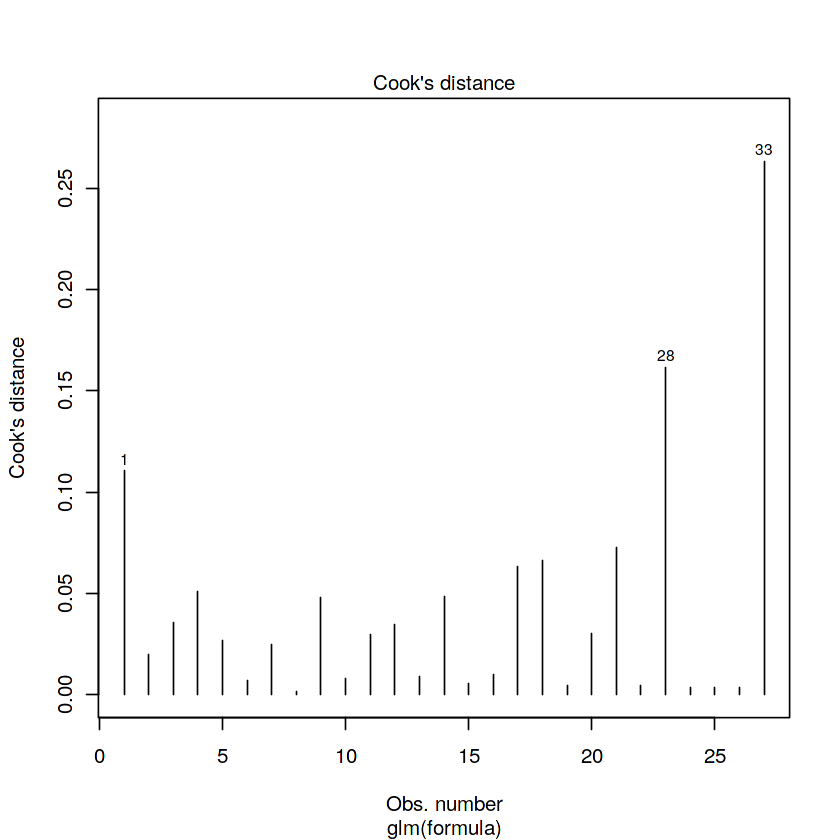

In [36]:
#Plotting Cook's Distance Plot
plot(QualityLog, which = 4, id.n = 3)

In [37]:
#Exploring Multicollinearity
model=lm(formula, data=data)
car::vif(model)

rejection      time   patient 
 1.170818  1.158899  1.055647

In [38]:
#Wald Test
library(car)
model=glm(formula, data=data)
Anova(model, type="II", test="Wald")

,Df,Chisq,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>
rejection,1,0.08156433,0.775188566
time,1,8.20781158,0.004171043
patient,1,3.05640615,0.080419357
